### Initialization

In [ ]:
import os, glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [ ]:
import network_flow_tracker.linking as NFTLinking
import network_flow_tracker.FlowGraph as FG
import network_flow_tracker.LFBFP as LFBFP
from network_flow_tracker.EdgeFlow import EdgeFlow
from network_flow_tracker.evaluation import TraceGenerator
from network_flow_tracker.visualization import vis_branch_acc_vs_flow_speed

from network_flow_tracker.utils import io, vis, stat, util
from network_flow_tracker.utils import neighbors as nb

In [ ]:
data_group = 'Lightfield'
dataset = 'Zhang2020'
data_root_path = f'C:\\Data\\{data_group}\\{dataset}'
process_data_root = os.path.join(data_root_path, 'processed_data')
vis_folder_root = os.path.join(data_root_path, 'method')

info_fp = os.path.join(process_data_root, 'data_info.pickle')
data_info = io.load_data(info_fp)
mm2s_to_pxl2s = 1e3 / data_info['frame_rate_Hz'] / data_info['target_voxel_size_um']
voxel_size_um = data_info['target_voxel_size_um']

In [ ]:
debug_Q = False
rm_node_voxel_on_vol_boundary_Q = True

z_idx = 1
# Load the stitched mask 
z_folder_name = data_info['raw_data_folders'][z_idx]
stitch_data_fp = os.path.join(process_data_root, 'itk', 'recon', 'whole_20250614_140908_data.mat')
stitch_data = LFBFP.LFBFProcessing.load_and_parse_annotation_data(stitch_data_fp)
sv_data = LFBFP.LFBFProcessing.get_subvol_data(data_info, stitch_data, z_idx)
sv_disp_vec = sv_data['disp_vec']
mask_size = sv_data['mask_size']
whole_mask_size = stitch_data['mask_size']
vsl_mips = vis.compute_three_view_mip(sv_data['im'])
vsl_mask = sv_data['label_array'] > 0

avg_hematocrit = 0.5
cell_labeled_fraction = 0.1
# visual check 
if debug_Q:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    # This vascular image has been high-pass-filtered. Large vessel might have black reigon inside. 
    ax.imshow(vsl_mips['yx'], cmap='gray')
    ax.scatter(sv_data['skl_sub'][2], sv_data['skl_sub'][1], 0.25, color='r', alpha=0.3)

Remove 27 node voxels on the sub-volume boundary


In [6]:
skl_r_array = np.zeros(sv_data['mask_size'], np.float16)
skl_r_array.flat[sv_data['skl_ind']] = sv_data['skl_r_v']
skl_label_array = np.zeros(sv_data['mask_size'], dtype=np.int8)
skl_label_array.flat[sv_data['skl_ind']] = sv_data['skl_label_v']
fg = FG.FlowGraph(skl_label_array > 0)
fg.init_nearest_skl_map(vsl_skl_labeled=skl_label_array, vsl_vol_labeled=sv_data['label_array'])
fg

11 skeleton voxels are labeled as vein in vsl_skl_labeled, but as capillary in vsl_vol_labeled. Correct to capillary.


Spatial graph with 945 edges and 458 nodes.

In [ ]:
# Pre-computed tracking results: 
data_folder = os.path.join(process_data_root, 'tracking')
data_fp = sorted(glob.glob(os.path.join(data_folder, f"{z_folder_name}_tk_w_pdt*")))
if len(data_fp) > 1: 
    data_fp = data_fp[-1]
else: 
    data_fp = data_fp[0]

tk_data = io.load_data(data_fp)

fg.init_velocity(tk_data['edge_v_pxl'], tk_data['edge_v_std_pxl'], tk_data['edge_track_frac'])

In [9]:
edge_v_mm_s = np.abs(fg.edge_v_pxl / mm2s_to_pxl2s) 
v_bin = np.linspace(0, 10, 21)
v_bin_val = (v_bin[1:] + v_bin[:-1]) / 2
edge_v_idx = util.get_x_idx_in_bin(edge_v_mm_s, v_bin)

In [10]:
min_nonzero_v = 3
edge_v_est = tk_data['edge_v_pxl'].copy()
# accelerate slow edges
tmp_is_slow_edge_Q = np.logical_and(np.abs(edge_v_est) < min_nonzero_v, edge_v_est != 0)
edge_v_est[tmp_is_slow_edge_Q] = np.sign(edge_v_est[tmp_is_slow_edge_Q]) * min_nonzero_v
fg.init_velocity(edge_v_est, tk_data['edge_v_std_pxl'], tk_data['edge_track_frac'])

In [13]:
np.count_nonzero(np.isfinite(edge_v_est))

820

## Generate simulation data

In [14]:
ptrace_result = tk_data['tracking_ns']
ptrace_el_to_idx = util.get_table_value_to_idx_dict(ptrace_result, key='edge_label', 
                                                       filter=lambda x: x>=0)
num_frames = ptrace_result.frame.max() - ptrace_result.frame.min() + 1
has_one_ep_Q = np.sum(fg.edge.connected_node_label == -1, axis=1) == 1
is_inflow_Q = fg.edge_v_pxl < 0
in_flow_el = np.where(np.logical_and(has_one_ep_Q, is_inflow_Q))[0]
# somehow there are some inflow edges without any detection ... probably inferred velocity 
in_el_num_detection = np.array([len(ptrace_el_to_idx[el]) if el in ptrace_el_to_idx else 0 for el in in_flow_el])
has_detection_Q = in_el_num_detection > 0
in_flow_el = in_flow_el[has_detection_Q]
in_flow_num_detection = in_el_num_detection[has_detection_Q]
in_flow_v = fg.edge_v_pxl[in_flow_el]
in_flow_v_std = fg.edge_v_std_pxl[in_flow_el]
in_flow_len = fg.e_length[in_flow_el]
in_flow_dect_den = in_flow_num_detection / in_flow_len / num_frames
in_flow_num_entr_per_frame = np.abs(in_flow_dect_den * in_flow_v)

In [15]:
in_flow_el.size

162

In [149]:
p_int_mean = 1e4
p_int_std = 2e3
trace_gen = TraceGenerator(fg, in_flow_el, in_flow_num_entr_per_frame, 
                           int_mean=p_int_mean, int_std=p_int_std)

In [153]:
num_particle = 0
sim_detect_list = []
# num_sim_frame = num_file
num_sim_frame = 1500
phase_seperation_n = 1.0

In [ ]:
for v_cv in [0, 0.1, 0.2, 0.3, 0.4]: 
    sim_detect_list = trace_gen.generate_detection_sequence(num_sim_frame, v_cv=v_cv, 
                                                            high_occ_th=0.5, phase_seperation_n=phase_seperation_n)
    sim_detect_table = trace_gen.detection_list_to_dataframe(sim_detect_list)
    sim_data = {'edge_v_est': edge_v_est, 
                'edge_v_std_pxl': tk_data['edge_v_std_pxl'], 
                'edge_track_frac': tk_data['edge_track_frac'],
                'detections': sim_detect_table}

    sim_data_fp = os.path.join(process_data_root, 'simulation', f"{z_folder_name}_simulated_detections_vcv_{int(v_cv * 100):03}_n{int(phase_seperation_n * 100)}.pickle")
    os.makedirs(os.path.dirname(sim_data_fp), exist_ok=True)
    io.save_data(sim_data_fp, sim_data)

## Apply tracking to simulation data

In [ ]:
v_cv = 0.3
phase_seperation_n = 1.0
sim_data_fp = os.path.join(process_data_root, 'simulation', f"{z_folder_name}_simulated_detections_vcv_{int(v_cv * 100):03}_n{int(phase_seperation_n * 100)}.pickle")
sim_data = io.load_data(sim_data_fp)
fg.init_velocity(sim_data['edge_v_est'], sim_data['edge_v_std_pxl'], sim_data['edge_track_frac'])
sim_detections = sim_data['detections']

In [25]:
s_num_frame = sim_detections['frame'].max() + 1 
sim_pid_to_idx = util.bin_data_to_idx_list(sim_detections.pid.values, return_type='dict')

In [15]:
sim_detections['did'] = np.arange(sim_detections.shape[0], dtype=np.int64)
sim_detections['ind'] = fg.edge.sub2ind(sim_detections[['z', 'y', 'x']].values.T)
sim_detections['skl_ind'] = fg.nearest_map.ind_to_nearest_ind(sim_detections.ind.values)
sim_detections['edge_label'] = fg.edge.ind_to_label(sim_detections['skl_ind'].values)
sim_detections['node_label'] = fg.node.ind_to_label(sim_detections['skl_ind'].values)

init_default_id = -1
normal_exit_id = -2
abnormal_exit_id = -3
gt_link_target = TraceGenerator.detection_table_to_link_idx(sim_detections, init_default_id, normal_exit_id, abnormal_exit_id)

In [33]:
strace_el_to_idx = util.get_table_value_to_idx_dict(sim_detections, key='edge_label', filter=lambda x: x>=0)
s_el_num_detection = np.array([len(strace_el_to_idx[el]) if el in strace_el_to_idx else 0 for el in ptrace_el_to_idx])
s_in_el_num_detection = np.array([len(strace_el_to_idx[el]) if el in strace_el_to_idx else 0 for el in in_flow_el])

In [31]:
s_el_num_detection.shape

(779,)

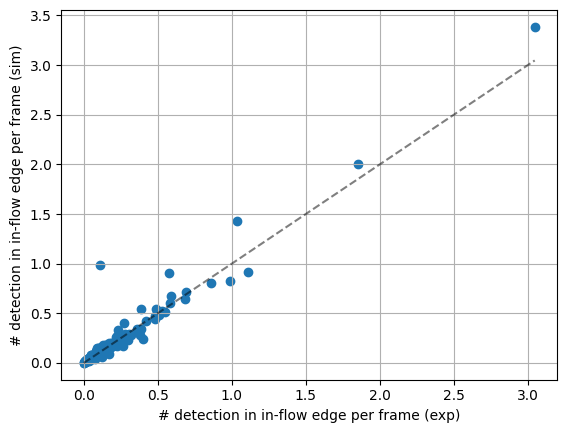

In [34]:
f, a = plt.subplots()
a.scatter(in_flow_num_detection / num_frames, s_in_el_num_detection / s_num_frame)
a.set_xlabel('# detection in in-flow edge per frame (exp)')
a.set_ylabel('# detection in in-flow edge per frame (sim)')
a.plot([0, max(in_flow_num_detection / num_frames)], [0, max(in_flow_num_detection / num_frames)], 'k--', alpha=0.5)
a.grid()

In [13]:
valid_Q = (gt_link_target != -1)
test_detections = sim_detections.drop(columns=['pid', 'exit_Q', 'exit_network_Q'])
edge_label_to_idx = util.get_table_value_to_idx_dict(test_detections[valid_Q], key='edge_label', 
                                                       filter=lambda x: x>=0)

In [14]:
max_speed_pxl = 20
particle_key = 'particle'
min_len = 1

In [15]:
# naive tracking
fg.configure_trackpy_query(search_range=max_speed_pxl, num_nb=10, predictQ=False)
cv_trace = NFTLinking.tracking(test_detections, max_speed_pxl, pos_col=['z', 'y', 'x'], output_type='table')
cv_p_ind = LFBFP.Linking.select_long_trajectories_from_trackpy_result(cv_trace, min_len, sortedQ=0, 
                                                                             particle_key=particle_key, return_dict_Q=True)

Finish configuring trackpy query function.  {'search_range': 20, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': False, 'gdistQ': True, 'v_error_frac': 0.5, 'v_error_min': 5, 'compare_feature': [], 'feature_cost_max': 10}
Finish processing frame 0. 

Finish processing frame 1499. Finish tracking cells. 


In [62]:
cv_stat, cv_link_target = TraceGenerator.analyze_tracking_result(cv_trace, gt_link_target, edge_label_to_idx, edge_v_idx)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_branch_acc_vs_flow_speed_cv_030_maxspeed_20_cv.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_branch_acc_vs_flow_speed_cv_030_maxspeed_20_cv.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_branch_acc_vs_flow_speed_cv_030_maxspeed_20_cv.png


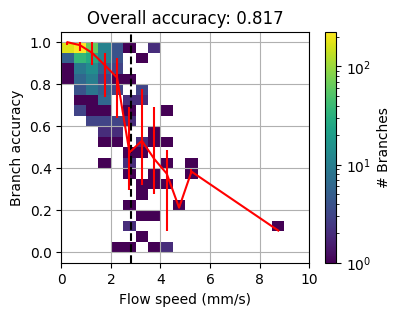

In [63]:
f, a = vis_branch_acc_vs_flow_speed(edge_v_mm_s, cv_stat, v_bin, max_speed_pxl, mm2s_to_pxl2s)
fig_fp = os.path.join(vis_folder_root, f"{z_folder_name}_branch_acc_vs_flow_speed_cv_{int(v_cv * 100):03}_maxspeed_{max_speed_pxl}_cv.png")
io.print_image_in_several_formats(f, fig_fp)

### Predictive tracking

In [28]:
# max_speed_pxl = 20
v_error_frac = 0.75
v_error_min = 10
feature_list = ['peak_int']
result_log = []

fg.configure_trackpy_query(search_range=max_speed_pxl, num_nb=10, max_exit_travel=0, predictQ=True, 
                           v_error_frac=v_error_frac, v_error_min=v_error_min, compare_feature=feature_list)
nft_trace = NFTLinking.tracking(test_detections, max_speed_pxl, pos_col=['z', 'y', 'x'], feature_col=feature_list, 
                                dist_func=fg.trackpy_query, output_type='table')

Finish configuring trackpy query function.  {'search_range': 20, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': True, 'gdistQ': True, 'v_error_frac': 0.75, 'v_error_min': 10, 'compare_feature': ['peak_int'], 'feature_cost_max': 10}
Finish processing frame 0. 

Finish processing frame 1499. Finish tracking cells. 


In [29]:
nft_stat, nft_link_target = TraceGenerator.analyze_tracking_result(nft_trace, gt_link_target, edge_label_to_idx, edge_v_idx)
nft_stat['stat']

{'true_positive_Q': 0.8414927768860353,
 'false_connection_Q': 0.018642990904226858,
 'false_positive_connection_Q': 0.00986490101658641,
 'false_positive_Q': 0.02850789192081327,
 'true_negative_Q': 0.10838014981273408,
 'false_negative_Q': 0.021619181380417334,
 'true_normal_exit_Q': 0.09587903513465311,
 'false_normal_exit_Q': 0.020749732477260568,
 'true_abnormal_exit_Q': 0.012010656322454075,
 'false_abnormal_exit_Q': 0.0013599072587836634,
 'num_links': 179424,
 'precision': 0.9672323222093228,
 'recall': 0.9749520431006893,
 'accuracy': 0.9498729172000402,
 'f1': 0.9710768356279055}

In [87]:
nft_stat, nft_link_target = TraceGenerator.analyze_tracking_result(nft_trace, gt_link_target, edge_label_to_idx, edge_v_idx)
nft_stat['stat']

{'true_positive_Q': 0.870670177524845,
 'false_connection_Q': 0.0036977264361958153,
 'false_positive_connection_Q': 0.01008522325094142,
 'false_positive_Q': 0.013782949687137235,
 'true_negative_Q': 0.10901780911124324,
 'false_negative_Q': 0.006529063676774541,
 'true_normal_exit_Q': 0.0950876298875959,
 'false_normal_exit_Q': 0.006529063676774541,
 'true_abnormal_exit_Q': 0.013930179223647329,
 'false_abnormal_exit_Q': 0.0,
 'num_links': 176595,
 'precision': 0.98441640477348,
 'recall': 0.9925569091995566,
 'accuracy': 0.9796879768392085,
 'f1': 0.9884698920708667}

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_branch_acc_vs_flow_speed_cv_030_maxspeed_20_nft.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_branch_acc_vs_flow_speed_cv_030_maxspeed_20_nft.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_branch_acc_vs_flow_speed_cv_030_maxspeed_20_nft.png


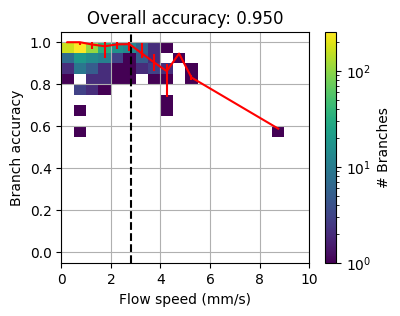

In [30]:
f, a = vis_branch_acc_vs_flow_speed(edge_v_mm_s, nft_stat, v_bin, max_speed_pxl, mm2s_to_pxl2s)

fig_fp = os.path.join(vis_folder_root, f"{z_folder_name}_branch_acc_vs_flow_speed_cv_{int(v_cv * 100):03}_maxspeed_{max_speed_pxl}_nft.png")
io.print_image_in_several_formats(f, fig_fp)

## Comparison

### CV different length 

In [22]:
tracking_algo_name = 'cv'

In [ ]:
max_speed_list = [10, 15, 20, 25, 30]
cmp_cv_data = {}
for max_speed_pxl in max_speed_list:
    fg.configure_trackpy_query(search_range=max_speed_pxl, num_nb=10, predictQ=False)
    cv_trace = NFTLinking.tracking(test_detections, max_speed_pxl, pos_col=['z', 'y', 'x'], output_type='table')
    cv_stat, cv_link_target = TraceGenerator.analyze_tracking_result(cv_trace, gt_link_target, edge_label_to_idx, edge_v_idx)
    cmp_cv_data[max_speed_pxl] = {'trace': cv_trace, 'stat': cv_stat, 'link_target': cv_link_target}

  0%|          | 0/5 [00:00<?, ?it/s]

Finish configuring trackpy query function.  {'search_range': 10, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': False, 'gdistQ': True, 'v_error_frac': 0.5, 'v_error_min': 5, 'compare_feature': [], 'feature_cost_max': 10}
Finish processing frame 8. 

Finish processing frame 1499. Finish tracking cells. 


 20%|██        | 1/5 [00:08<00:33,  8.29s/it]

Finish configuring trackpy query function.  {'search_range': 15, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': False, 'gdistQ': True, 'v_error_frac': 0.5, 'v_error_min': 5, 'compare_feature': [], 'feature_cost_max': 10}
Finish processing frame 1499. Finish tracking cells. 


 40%|████      | 2/5 [00:16<00:25,  8.47s/it]

Finish configuring trackpy query function.  {'search_range': 20, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': False, 'gdistQ': True, 'v_error_frac': 0.5, 'v_error_min': 5, 'compare_feature': [], 'feature_cost_max': 10}
Finish processing frame 1499. Finish tracking cells. 


 60%|██████    | 3/5 [00:26<00:18,  9.16s/it]

Finish configuring trackpy query function.  {'search_range': 25, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': False, 'gdistQ': True, 'v_error_frac': 0.5, 'v_error_min': 5, 'compare_feature': [], 'feature_cost_max': 10}
Finish processing frame 1499. Finish tracking cells. 


 80%|████████  | 4/5 [00:38<00:10, 10.27s/it]

Finish configuring trackpy query function.  {'search_range': 30, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': False, 'gdistQ': True, 'v_error_frac': 0.5, 'v_error_min': 5, 'compare_feature': [], 'feature_cost_max': 10}
Finish processing frame 1499. Finish tracking cells. 


100%|██████████| 5/5 [00:59<00:00, 11.84s/it]


In [24]:
data_fp = os.path.join(dm_server.fp_processed_data_root(), 'simulation', f"{z_folder_name}_cv_{int(v_cv * 100):03}_n{int(phase_seperation_n * 100)}_tk_algo_{tracking_algo_name}_para_sweep_result.pickle")
dm.save_data(data_fp, cmp_cv_data)

In [25]:
# Combine overall statistics
num_para_sets = len(cmp_cv_data)
cv_para_scan_stat = defaultdict(lambda: np.full(num_para_sets, np.nan, dtype=object))
for i, (k, v) in enumerate(cmp_cv_data.items()):
    cv_para_scan_stat['max_speed_pxl'][i] = k           
    for kk, vv in v['stat']['stat'].items():
        if not isinstance(vv, dict):
            cv_para_scan_stat[kk][i] = vv

cv_para_scan_stat = pd.DataFrame(cv_para_scan_stat)
fp = os.path.join(vis_folder_root, f"{z_folder_name}_cv_{int(v_cv * 100):03}_n{int(phase_seperation_n * 100)}_{tracking_algo_name}_para_sweep_stat.csv")
cv_para_scan_stat.to_csv(fp, index=False)

In [26]:
cv_para_scan_stat

,max_speed_pxl,true_positive_Q,false_connection_Q,false_positive_connection_Q,false_positive_Q,true_negative_Q,false_negative_Q,true_normal_exit_Q,false_normal_exit_Q,true_abnormal_exit_Q,false_abnormal_exit_Q,num_links,precision,recall,accuracy,f1
0,10,0.677504,0.084413,0.030383,0.114796,0.084175,0.123525,0.0,0.0,0.013372,0.194328,185007,0.855111,0.845792,0.761679,0.850426
1,15,0.72981,0.089337,0.036728,0.126066,0.077829,0.066295,0.0,0.0,0.011886,0.132238,185007,0.852706,0.916726,0.80764,0.883558
2,20,0.754236,0.092656,0.042031,0.134687,0.072527,0.03855,0.0,0.0,0.010578,0.100499,185007,0.848483,0.951374,0.826763,0.896988
3,25,0.761782,0.097315,0.04762,0.144935,0.066938,0.026345,0.0,0.0,0.009454,0.083829,185007,0.840154,0.966573,0.82872,0.898941
4,30,0.760706,0.104812,0.054079,0.158891,0.060479,0.019924,0.0,0.0,0.0084,0.072003,185007,0.827217,0.974478,0.821185,0.894829


Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Median_tracking_accuracy_vs_flow_speed_cv_00_n100_tk_alg_cv.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Median_tracking_accuracy_vs_flow_speed_cv_00_n100_tk_alg_cv.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Median_tracking_accuracy_vs_flow_speed_cv_00_n100_tk_alg_cv.png
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Median_tracking_precision_vs_flow_speed_cv_00_n100_tk_alg_cv.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Median_tracking_precision_vs_flow_speed_cv_00_n100_tk_alg_cv.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Median_tracking_precision_vs_flow_speed_cv_00_n100_tk_alg_cv.png
Finish saving

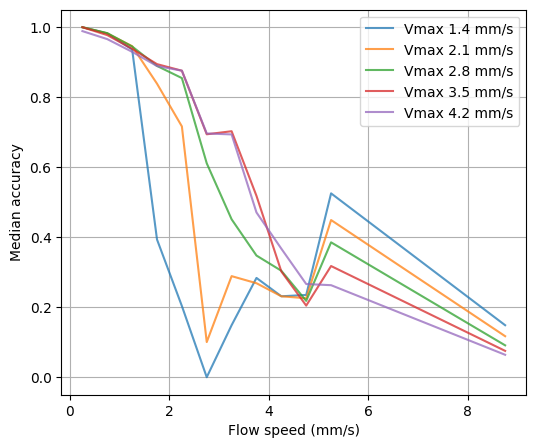

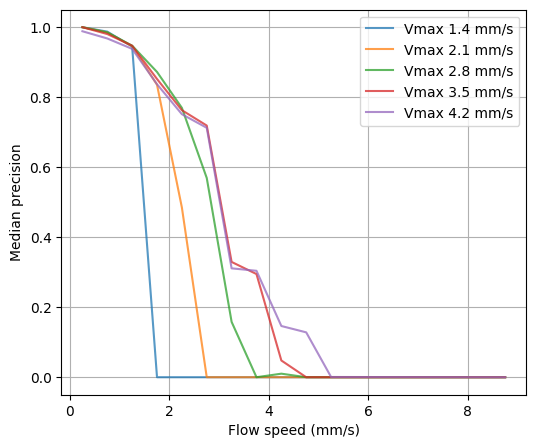

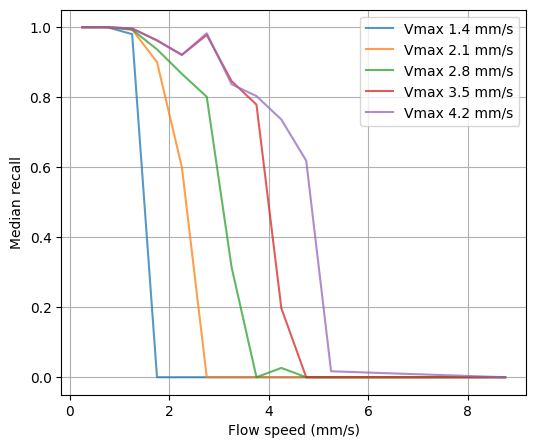

In [28]:
vis_key = ['accuracy', 'precision', 'recall']
stat_key = 'ptrl'
for vk in vis_key:
    f, a = plt.subplots(1, 1, figsize=(6, 5))
    for k, v in cmp_cv_data.items():
        vis_eb_x = v_bin_val
        vis_eb_y = v['stat']['branch'][f'{vk}_{stat_key}']
        if vis_eb_y.ndim == 1:
            vis_eb_y = vis_eb_y[:, np.newaxis]
        vis_valid_Q = np.all(~np.isnan(vis_eb_y), axis=1)
        vis_eb_x = vis_eb_x[vis_valid_Q]
        vis_eb_y = vis_eb_y[vis_valid_Q]
        if vis_eb_y.shape[1] == 3: 
            vis_eb_y = vis_eb_y[:, 1]
        a.plot(vis_eb_x, vis_eb_y, '-', label=f"Vmax {k/mm2s_to_pxl2s:.1f} mm/s", alpha=0.75)
    a.legend()
    a.grid()
    a.set_ylim(-0.05, 1.05)
    a.set_xlabel('Flow speed (mm/s)')
    if stat_key == 'mean':
        vis_x_prefix = 'Average'
    elif stat_key == 'ptrl':
        vis_x_prefix = 'Median'
    a.set_ylabel(f'{vis_x_prefix} {vk}')
    fig_fp = os.path.join(vis_folder_root, f"{z_folder_name}_{vis_x_prefix}_tracking_{vk}_vs_flow_speed_cv_{int(v_cv * 100):02}_n{int(phase_seperation_n * 100)}_tk_alg_{tracking_algo_name}.png")
    io.print_image_in_several_formats(f, fig_fp)    

## NFT different length

In [29]:
tracking_algo_name = 'nft'

In [30]:
# parameter list: 
max_speed_pxl = 20
v_error_frac = 0.75
v_error_min = 10
feature_list = ('peak_int',)
feature_cost_max = 10
nft_para_name_list = ['max_speed_pxl', 'v_error_frac', 'v_error_min', 'feature_list', 'feature_cost_max']
nft_para_list = []
nft_result = []

max_speed_list = [10, 15, 20, 25, 30]
for tmp_v_max in max_speed_list:
    nft_para_list.append((tmp_v_max, v_error_frac, v_error_min, feature_list, feature_cost_max))
v_error_min_list = [5, 10, 15]
for tmp_v_min in v_error_min_list:
    nft_para_list.append((max_speed_pxl, v_error_frac, tmp_v_min, feature_list, feature_cost_max))

v_error_frac_list = [0.25, 0.5, 0.75, 1.0]
for tmp_v_frac in v_error_frac_list:
    nft_para_list.append((max_speed_pxl, tmp_v_frac, v_error_min, feature_list, feature_cost_max))

feature_list_opts = [(), ('peak_int',)]
for tmp_feature_list in feature_list_opts:
    nft_para_list.append((max_speed_pxl, v_error_frac, v_error_min, tmp_feature_list, feature_cost_max))

for tmp_feature_cost_max in [5, 15]: 
    nft_para_list.append((max_speed_pxl, v_error_frac, v_error_min, feature_list, tmp_feature_cost_max))

nft_para_list = sorted(list(set(nft_para_list)))

In [ ]:
nft_data = {}
for para in nft_para_list:
    tmp_max_speed_pxl, tmp_v_error_frac, tmp_v_error_min, tmp_feature_list, tmp_feature_cost_max = para
    feature_list = list(feature_list)

    fg.configure_trackpy_query(search_range=tmp_max_speed_pxl, num_nb=10, max_exit_travel=0, predictQ=True, 
                               v_error_frac=tmp_v_error_frac, v_error_min=tmp_v_error_min, compare_feature=feature_list, feature_cost_max=tmp_feature_cost_max)
    nft_trace = NFTLinking.tracking(test_detections, tmp_max_speed_pxl, pos_col=['z', 'y', 'x'], feature_col=feature_list, 
                                    dist_func=fg.trackpy_query, output_type='table')
    nft_stat, nft_link_target = TraceGenerator.analyze_tracking_result(nft_trace, gt_link_target, edge_label_to_idx, edge_v_idx)
    nft_data[para] = {'trace': nft_trace, 'stat': nft_stat, 'link_target': nft_link_target}

In [ ]:
data_fp = os.path.join(process_data_root, 'simulation', f"{z_folder_name}_cv_{int(v_cv * 100):03}_n{int(phase_seperation_n * 100)}_tk_algo_{tracking_algo_name}_para_sweep_result.pickle")
io.save_data(data_fp, nft_data)

In [34]:
# Combine overall statistics
num_para_sets = len(nft_para_list)
para_scan_stat = defaultdict(lambda: np.full(num_para_sets, np.nan, dtype=object))
for i, (k, v) in enumerate(nft_data.items()):

    for j, kk in enumerate(nft_para_name_list): 
            para_scan_stat[kk][i] = k[j]
        
    for kk, vv in v['stat']['stat'].items():
        if not isinstance(vv, dict):
            para_scan_stat[kk][i] = vv

para_scan_stat = pd.DataFrame(para_scan_stat)
fp = os.path.join(vis_folder_root, f"{z_folder_name}_cv_{int(v_cv * 100):03}_n{int(phase_seperation_n * 100)}_{tracking_algo_name}_para_sweep_stat.csv")
para_scan_stat.to_csv(fp, index=False)

In [35]:
para_scan_stat

,max_speed_pxl,v_error_frac,v_error_min,feature_list,feature_cost_max,true_positive_Q,false_connection_Q,false_positive_connection_Q,false_positive_Q,true_negative_Q,false_negative_Q,true_normal_exit_Q,false_normal_exit_Q,true_abnormal_exit_Q,false_abnormal_exit_Q,num_links,precision,recall,accuracy,f1
0,10,0.75,10,"(peak_int,)",10,0.88148,0.001443,0.003567,0.005011,0.11099,0.002519,0.095088,0.002519,0.015902,0.0,185007,0.994348,0.997151,0.992471,0.995747
1,15,0.75,10,"(peak_int,)",10,0.878453,0.00267,0.006551,0.009221,0.108007,0.004319,0.093878,0.004319,0.014129,0.0,185007,0.989612,0.995108,0.98646,0.992352
2,20,0.25,10,"(peak_int,)",10,0.878313,0.002005,0.007756,0.009762,0.106801,0.005124,0.092683,0.005124,0.014118,0.0,185007,0.989008,0.9942,0.985114,0.991597
3,20,0.5,10,"(peak_int,)",10,0.877097,0.002697,0.008508,0.011205,0.10605,0.005648,0.092596,0.005648,0.013454,0.0,185007,0.987386,0.993601,0.983147,0.990484
4,20,0.75,5,"(peak_int,)",10,0.87601,0.003476,0.009162,0.012637,0.105396,0.005957,0.092564,0.005957,0.012832,0.0,185007,0.985779,0.993246,0.981406,0.989499
5,20,0.75,10,(),10,0.875745,0.003432,0.009437,0.01287,0.10512,0.006265,0.09238,0.006265,0.01274,0.0,185007,0.985517,0.992897,0.980866,0.989193
6,20,0.75,10,"(peak_int,)",5,0.875388,0.003535,0.009713,0.013248,0.104845,0.006519,0.092105,0.006519,0.01274,0.0,185007,0.985092,0.992608,0.980233,0.988836
7,20,0.75,10,"(peak_int,)",10,0.875751,0.003427,0.009437,0.012864,0.10512,0.006265,0.09238,0.006265,0.01274,0.0,185007,0.985523,0.992897,0.980871,0.989196
8,20,0.75,10,"(peak_int,)",15,0.876172,0.003303,0.009129,0.012432,0.105428,0.005967,0.092688,0.005967,0.01274,0.0,185007,0.98601,0.993235,0.981601,0.989609
9,20,0.75,15,"(peak_int,)",10,0.875432,0.003346,0.009762,0.013108,0.104796,0.006665,0.092261,0.006665,0.012535,0.0,185007,0.985248,0.992445,0.980228,0.988833


### Different maximum search range

In [36]:
max_speed_pxl = 20
v_error_frac = 0.75
v_error_min = 10
feature_list = ('peak_int',)
feature_cost_max = 10
nft_para_name_list = ['max_speed_pxl', 'v_error_frac', 'v_error_min', 'feature_list', 'feature_cost_max']
compare_list = []
feature_list_opts = ('peak_int',)
for tmp_speed in max_speed_list:
    compare_list.append((tmp_speed, v_error_frac, v_error_min, feature_list_opts, feature_cost_max))
compare_results = [nft_data[k] for k in compare_list]

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Average_tracking_accuracy_vs_flow_speed_cv_00_n100_tk_alg_nft_vmin_10_vfrac_0.75.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Average_tracking_accuracy_vs_flow_speed_cv_00_n100_tk_alg_nft_vmin_10_vfrac_0.75.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Average_tracking_accuracy_vs_flow_speed_cv_00_n100_tk_alg_nft_vmin_10_vfrac_0.75.png
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Average_tracking_precision_vs_flow_speed_cv_00_n100_tk_alg_nft_vmin_10_vfrac_0.75.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Average_tracking_precision_vs_flow_speed_cv_00_n100_tk_alg_nft_vmin_10_vfrac_0.75.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visua

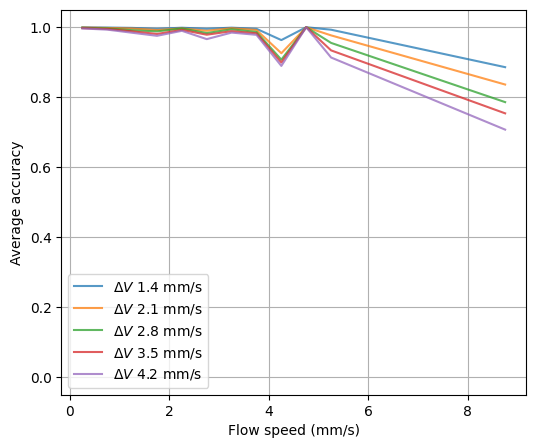

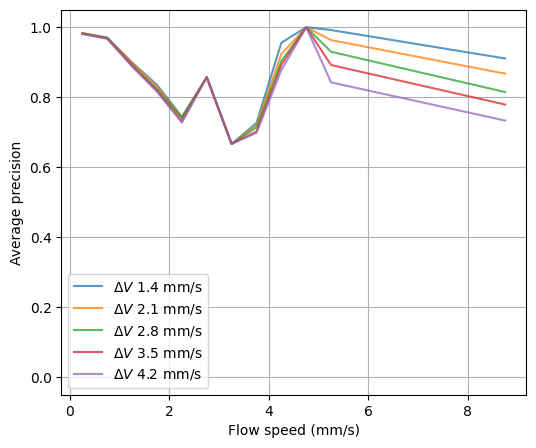

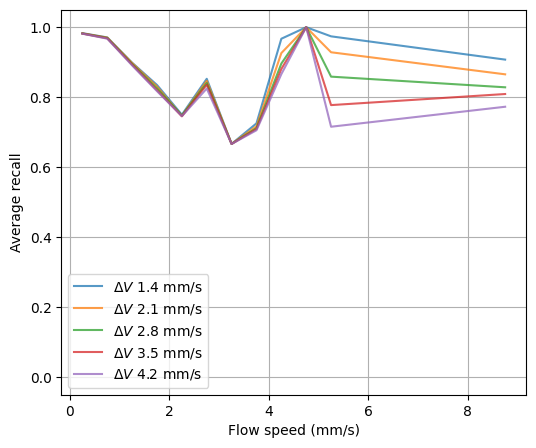

In [38]:
vis_key = ['accuracy', 'precision', 'recall']
stat_key = 'mean'
for vk in vis_key:
    f, a = plt.subplots(1, 1, figsize=(6, 5))
    for k, v in zip(max_speed_list, compare_results):
        vis_eb_x = v_bin_val
        vis_eb_y = v['stat']['branch'][f'{vk}_{stat_key}']
        if vis_eb_y.ndim == 1:
            vis_eb_y = vis_eb_y[:, np.newaxis]
        vis_valid_Q = np.all(~np.isnan(vis_eb_y), axis=1)
        vis_eb_x = vis_eb_x[vis_valid_Q]
        vis_eb_y = vis_eb_y[vis_valid_Q]
        if vis_eb_y.shape[1] == 3: 
            vis_eb_y = vis_eb_y[:, 1]
        a.plot(vis_eb_x, vis_eb_y, '-', label=f"$\Delta V$ {k/mm2s_to_pxl2s:.1f} mm/s", alpha=0.75)
        # a.errorbar(vis_eb_x, vis_eb_y[:, 1], 
        #         yerr=[vis_eb_y[:, 1] - vis_eb_y[:, 0], vis_eb_y[:, 2] - vis_eb_y[:, 1]], 
        #         fmt='-', label=f"Vmax {k/mm2s_to_pxl2s:.1f} mm/s", alpha=0.75)

    a.legend()
    a.grid()
    a.set_ylim(-0.05, 1.05)
    a.set_xlabel('Flow speed (mm/s)')
    if stat_key == 'mean':
        vis_x_prefix = 'Average'
    elif stat_key == 'ptrl':
        vis_x_prefix = 'Median'
    a.set_ylabel(f'{vis_x_prefix} {vk}')
    fig_fp = os.path.join(vis_folder_root, f"{z_folder_name}_{vis_x_prefix}_tracking_{vk}_vs_flow_speed_cv_{int(v_cv * 100):02}_n{int(phase_seperation_n * 100)}_tk_alg_{tracking_algo_name}_vmin_{v_error_min}_vfrac_{v_error_frac}.png")
    io.print_image_in_several_formats(f, fig_fp)    

In [42]:
v_bin_val

array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25,
       5.75, 6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75])

In [ ]:
# Edges with 0 precision or recall are edges with mostly true negative linkings 

array([ 14,  55,  60, 110, 144, 146, 150, 202, 226, 294, 297, 323, 338,
       396, 486, 505, 508, 519, 646, 748, 762, 826, 887, 898, 922])

In [49]:
v['stat']['true_negative_Q'][edge_label_to_idx[14]]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [45]:
v['stat']['branch']['recall'][edge_v_idx[4]]

array([0.        , 0.        ,        nan,        nan,        nan,
       0.99404762, 0.        , 0.        , 0.94      , 1.        ,
              nan, 1.        , 1.        , 1.        , 1.        ,
       1.        ,        nan,        nan,        nan, 1.        ,
       1.        , 1.        , 1.        ,        nan,        nan])

### Different v_max_frac

In [50]:
v_error_frac_list = [0.25, 0.5, 0.75, 1.0]
compare_list = []
for tmp_v_frac in v_error_frac_list:
    compare_list.append((max_speed_pxl, tmp_v_frac, v_error_min, feature_list, feature_cost_max))
compare_results = [nft_data[k] for k in compare_list]

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Average_tracking_accuracy_vs_flow_speed_cv_00_n100_tk_alg_nft_vmin_10_scan_vfrac.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Average_tracking_accuracy_vs_flow_speed_cv_00_n100_tk_alg_nft_vmin_10_scan_vfrac.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Average_tracking_accuracy_vs_flow_speed_cv_00_n100_tk_alg_nft_vmin_10_scan_vfrac.png
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Average_tracking_precision_vs_flow_speed_cv_00_n100_tk_alg_nft_vmin_10_scan_vfrac.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_Average_tracking_precision_vs_flow_speed_cv_00_n100_tk_alg_nft_vmin_10_scan_vfrac.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visua

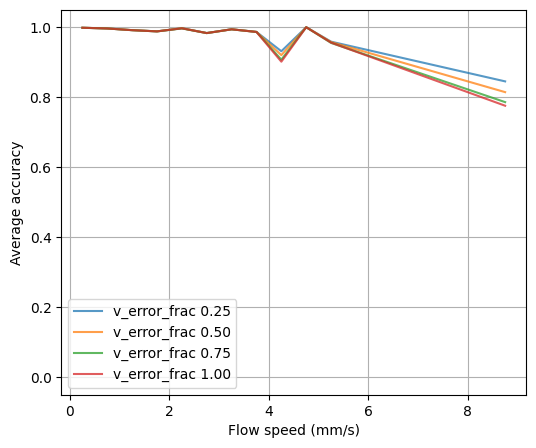

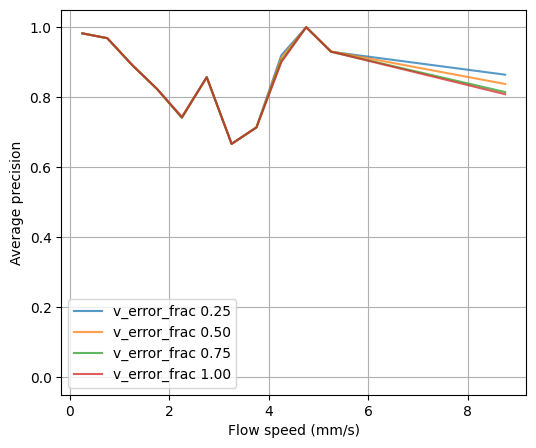

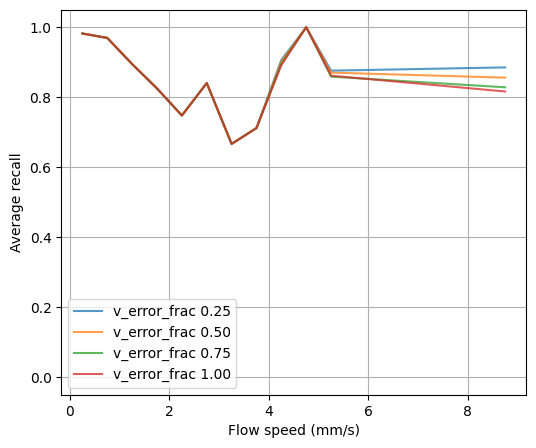

In [52]:
vis_key = ['accuracy', 'precision', 'recall']
stat_key = 'mean'
for vk in vis_key:
    f, a = plt.subplots(1, 1, figsize=(6, 5))
    for k, v in zip(v_error_frac_list, compare_results):
        vis_eb_x = v_bin_val
        vis_eb_y = v['stat']['branch'][f'{vk}_{stat_key}']
        if vis_eb_y.ndim == 1:
            vis_eb_y = vis_eb_y[:, np.newaxis]
        vis_valid_Q = np.all(~np.isnan(vis_eb_y), axis=1)
        vis_eb_x = vis_eb_x[vis_valid_Q]
        vis_eb_y = vis_eb_y[vis_valid_Q]
        if vis_eb_y.shape[1] == 3: 
            vis_eb_y = vis_eb_y[:, 1]
        a.plot(vis_eb_x, vis_eb_y, '-', label=f"v_error_frac {k:.2f}", alpha=0.75)
        # a.errorbar(vis_eb_x, vis_eb_y[:, 1], 
        #         yerr=[vis_eb_y[:, 1] - vis_eb_y[:, 0], vis_eb_y[:, 2] - vis_eb_y[:, 1]], 
        #         fmt='-', label=f"Vmax {k/mm2s_to_pxl2s:.1f} mm/s", alpha=0.75)

    a.legend()
    a.grid()
    a.set_ylim(-0.05, 1.05)
    a.set_xlabel('Flow speed (mm/s)')
    if stat_key == 'mean':
        vis_x_prefix = 'Average'
    elif stat_key == 'ptrl':
        vis_x_prefix = 'Median'
    a.set_ylabel(f'{vis_x_prefix} {vk}')
    fig_fp = os.path.join(vis_folder_root, f"{z_folder_name}_{vis_x_prefix}_tracking_{vk}_vs_flow_speed_cv_{int(v_cv * 100):02}_n{int(phase_seperation_n * 100)}_tk_alg_{tracking_algo_name}_vmin_{v_error_min}_scan_vfrac.png")
    io.print_image_in_several_formats(f, fig_fp)    

### Single set of parameters

In [53]:
vis_para = (max_speed_pxl, v_error_frac, v_error_min, feature_list, feature_cost_max)
vis_data = nft_data[vis_para]

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_cv_000_n_100_nft_branch_acc_vs_flow_speed_hist_mv_20_vfrac_75_vmin_10.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_cv_000_n_100_nft_branch_acc_vs_flow_speed_hist_mv_20_vfrac_75_vmin_10.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/method/z100_250um_cv_000_n_100_nft_branch_acc_vs_flow_speed_hist_mv_20_vfrac_75_vmin_10.png


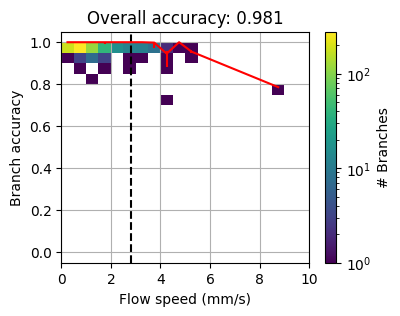

In [54]:
f, a = vis_branch_acc_vs_flow_speed(edge_v_mm_s, vis_data['stat'], v_bin, max_speed_pxl, mm2s_to_pxl2s, vis_val='accuracy')

fig_fp = os.path.join(vis_folder_root, f"{z_folder_name}_cv_{int(v_cv * 100):03}_n_{int(phase_seperation_n * 100)}_{tracking_algo_name}_branch_acc_vs_flow_speed_hist_mv_{vis_para[0]}_vfrac_{int(vis_para[1] * 100)}_vmin_{vis_para[2]}.png")
io.print_image_in_several_formats(f, fig_fp)